## March Madness Final Four Prediction Project
### MA326 Final Project
Dhivya Lakshminarayanan, Cecilia Gallegos Hernandez, Diego Sarria, Simone Smith

This sections loads the data and preprocesses it by encoding categorical variables and mapping postseason outcomes to numerical values, which allows for easier mathematical manipulation. The core of the section involves performing Singular Value Decomposition (SVD) on the numeric data to reduce dimensionality and identify principal components that capture the most variance within the dataset. These components are then used as features in a linear regression model to predict postseason results. The script evaluates the model's performance by calculating the mean squared error (MSE) across different numbers of SVD components to determine the optimal complexity for the model. Additionally, it calculates approximation errors to gauge how well the reduced data can reconstruct the original data, further helping in selecting the optimal number of components.

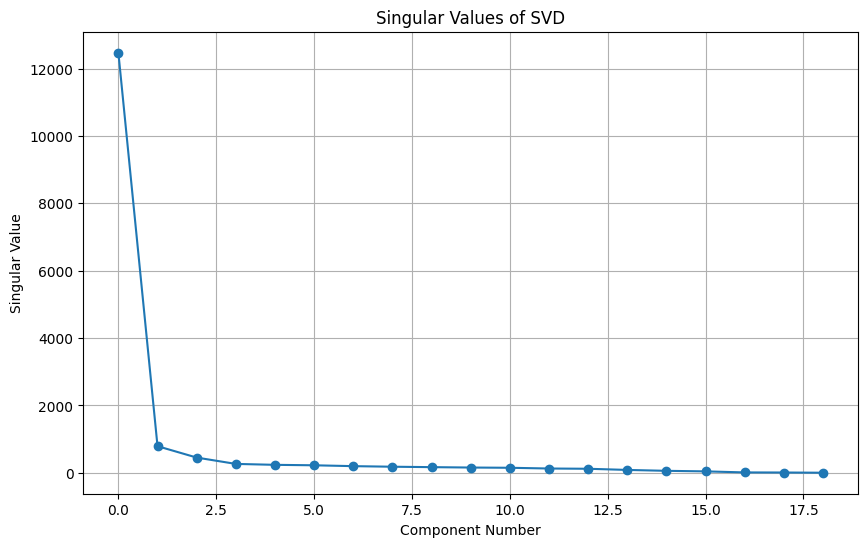

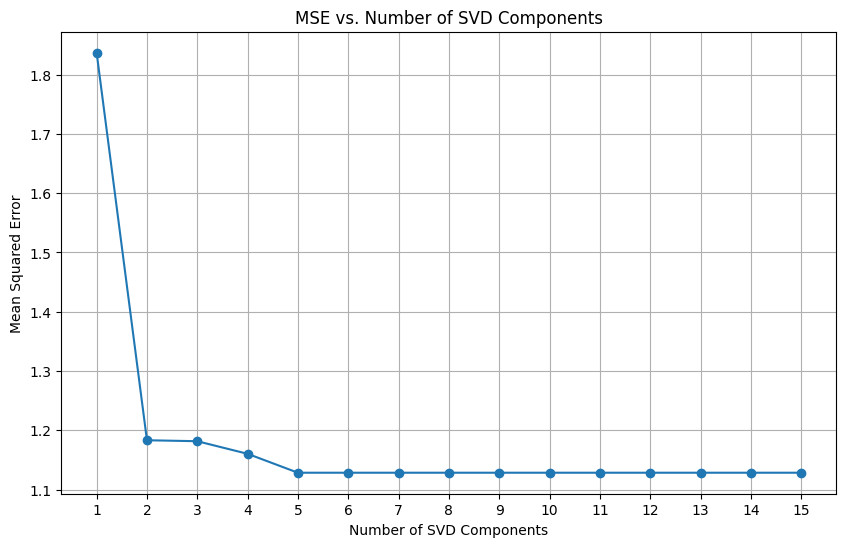

Mean Squared Error for the last model: 1.1284995047269362
Optimal amount of components: 5
Rank-r 1, Approximation Error: 790.5620
Rank-r 2, Approximation Error: 452.4464
Rank-r 3, Approximation Error: 264.3457
Rank-r 4, Approximation Error: 236.7311
Rank-r 5, Approximation Error: 223.2483
Rank-r 6, Approximation Error: 197.7423
Rank-r 7, Approximation Error: 180.7384
Rank-r 8, Approximation Error: 168.0825
Rank-r 9, Approximation Error: 156.5539
Rank-r 10, Approximation Error: 149.5134
Rank-r 11, Approximation Error: 127.4432
Rank-r 12, Approximation Error: 120.1195
Rank-r 13, Approximation Error: 85.5046
Rank-r 14, Approximation Error: 58.8702
Rank-r 15, Approximation Error: 42.4955
Optimal amount of components (2-norm): 15 



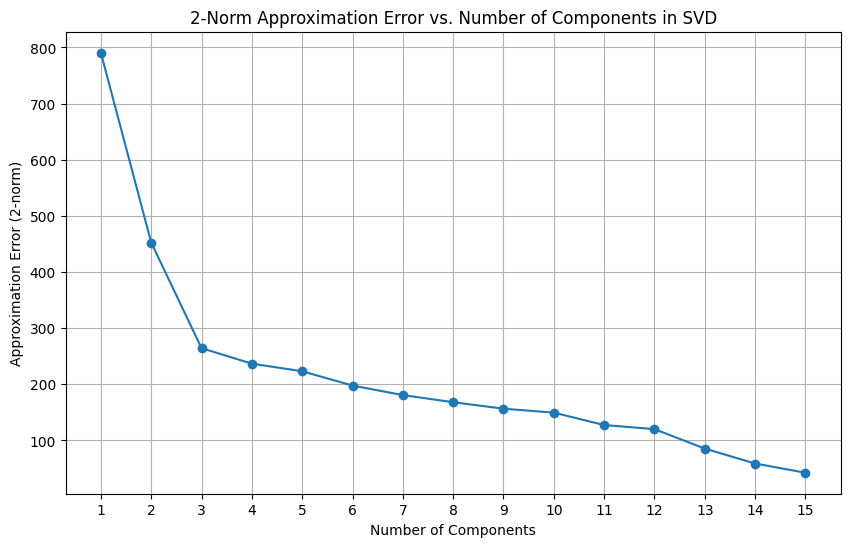

Top 5 Important Features: 
1 .)  G
2 .)  W
5 .)  BARTHAG
4 .)  ADJDE
3 .)  ADJOE


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv('./cbb.csv')

# Encode categorical variables
label_encoders = {}
categorical_cols = ['TEAM', 'CONF']
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col].fillna(''))

# Map postseason outcomes to numerical values
postseason_mapping = {
    'NA': 0, 'R68': 1, 'R64': 2, 'R32': 3, 'S16': 4, 'E8': 5, 'F4': 6, '2ND': 7, 'Champions': 8
}
df['POSTSEASON'] = df['POSTSEASON'].map(postseason_mapping)

# Prepare data for SVD, excluding non-numeric and target columns
numeric_data = df.drop(columns=['TEAM', 'CONF', 'POSTSEASON', 'SEED', 'YEAR']).astype(np.float64)

# Perform SVD
U, S, VT = np.linalg.svd(numeric_data, full_matrices=False)

# Plot singular values
plt.figure(figsize=(10, 6))
plt.plot(S, marker='o')
plt.xlabel('Component Number')
plt.ylabel('Singular Value')
plt.title('Singular Values of SVD')
plt.grid(True)
plt.show()


# Use SVD components for features
X = U[:, :5]  # Using first 5 components

# Clean dataset to remove NaN in target
df_cleaned = df.dropna(subset=['POSTSEASON'])
X = X[df_cleaned.index]
y = df_cleaned['POSTSEASON']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate model on different number of SVD components
components_range = range(1, 16)
mse_values = []

for k in components_range:
    X_train_k = X_train[:, :k]
    X_test_k = X_test[:, :k]

    model = LinearRegression()
    model.fit(X_train_k, y_train)
    y_pred = model.predict(X_test_k)

    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

# Plot MSE vs. number of components
plt.figure(figsize=(10, 6))
plt.plot(components_range, mse_values, marker='o')
plt.xlabel('Number of SVD Components')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Number of SVD Components')
plt.grid(True)
plt.xticks(components_range)
plt.show()

# Print last computed MSE for completeness
print('Mean Squared Error for the last model:', mse)


# Determine the optimal number of components based on minimum MSE
optimal_components = components_range[np.argmin(mse_values)]

print("Optimal amount of components:", optimal_components)


# Initialize lists to store approximation errors
approximation_errors = []

# Iterate over the range of ranks
for r in range(1, 16):
    # Compute the rank-r approximation
    A_r = np.dot(U[:, :r], np.dot(np.diag(S[:r]), VT[:r, :]))
    
    # Compute the approximation error using the 2-norm
    error = np.linalg.norm(df.drop(columns=['TEAM', 'CONF', 'POSTSEASON', 'SEED', 'YEAR']).values - A_r, ord=2)
    approximation_errors.append(error)

# Print the approximation errors
for r, error in enumerate(approximation_errors, start=1):
    print(f"Rank-r {r}, Approximation Error: {error:.4f}")

# Determine the optimal number of components based on minimum 2-norm approximation error
optimal_components_2norm = components_range[np.argmin(approximation_errors)]

print("Optimal amount of components (2-norm):", optimal_components_2norm, '\n')

# Plot the error vs. number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), approximation_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Approximation Error (2-norm)')
plt.title('2-Norm Approximation Error vs. Number of Components in SVD')
plt.grid(True)
plt.xticks(range(1, 16))
plt.show()

# Create the feature matrix X using the optimal number of components
X_train_optimal = X_train[:, :optimal_components]

# Create and train the linear regression model with the optimal components
model_optimal = LinearRegression()
model_optimal.fit(X_train_optimal, y_train)

# Get the coefficients of the linear regression model
coefficients = model_optimal.coef_

# Get the indices of the top 5 important features
top_5_indices = np.argsort(np.abs(coefficients))[-5:]

# Get the names of the features
feature_names = df.drop(columns=['TEAM', 'CONF', 'POSTSEASON', 'SEED', 'YEAR']).columns

# Print the top 5 important features
print("Top 5 Important Features: ")
for i in top_5_indices[::-1]:
    print(i+1 ,".) ",  feature_names[i])


### Linear Regression Model to predict final four teams in specific years
This section of the code is dedicated to making predictions about which teams from a specific year, 2018, are likely to reach the Final Four based on their season performance. It begins by filtering the data for 2018 and preparing it by extracting relevant features through Singular Value Decomposition (SVD), which simplifies the dataset while retaining the most significant information. These features are then used to make postseason predictions using the pre-trained model. The script identifies teams predicted to be in the Final Four by selecting the top four scores from the model's predictions and translates these from encoded team identifiers back to team names for readability.

Further, the script assesses the accuracy of these predictions by comparing them against the actual Final Four teams from 2018, providing a direct measure of prediction success. It does this by intersecting the set of predicted team names with the set of actual team names that reached the Final Four, ultimately calculating and displaying the number of correct predictions and the overall accuracy percentage. This evaluation helps in understanding the model's effectiveness and reliability in forecasting significant postseason outcomes based on regular season data.

In [2]:
import numpy as np

# Step 1: Filter the data for a specific year
specific_year = 2013
df_specific_year = df[df['YEAR'] == specific_year]

# Step 2: Process the data for prediction
# Extract necessary columns and perform SVD to get the top 5 components
X_specific_year = np.linalg.svd(
    df_specific_year.drop(columns=['TEAM', 'CONF', 'POSTSEASON', 'SEED', 'YEAR']).astype(np.float64), 
    full_matrices=False
)[0][:, :5]

# Step 3: Use the trained model to predict postseason results for the specific year
y_pred_specific_year = model.predict(X_specific_year)

# Step 4: Identify the teams predicted to reach the Final Four
# Get the indices of the top 4 predictions and extract their corresponding team names
final_four_indices = np.argsort(y_pred_specific_year)[-4:]
final_four_teams_names = label_encoders['TEAM'].inverse_transform(df_specific_year.iloc[final_four_indices]['TEAM'])

# Output the predicted Final Four teams
print("Predicted Final Four Teams for", specific_year, ":", final_four_teams_names.tolist())

# Step 5: Compare predictions against actual outcomes
# Filter the dataset for teams that actually reached the Final Four or better
actual_final_four_teams = df_specific_year[df_specific_year['POSTSEASON'].isin([6, 7, 8])]  # Mapping: F4=6, 2ND=7, Champions=8

# Extract the actual team names using inverse transformation
actual_final_four_team_names = label_encoders['TEAM'].inverse_transform(actual_final_four_teams['TEAM'])

# Output the actual Final Four teams
print("Actual Final Four Teams for", specific_year, ":", actual_final_four_team_names.tolist())

# Step 6: Calculate the accuracy of predictions
# Converting both lists to sets for easier comparison
predicted_teams_set = set(final_four_teams_names)
actual_teams_set = set(actual_final_four_team_names)

# Calculate intersection to find correctly predicted teams
correct_predictions = predicted_teams_set.intersection(actual_teams_set)

# Output the number of correct predictions and the prediction accuracy
print("Number of correct predictions:", len(correct_predictions))
print("Accuracy:", "{:.0%}".format(len(correct_predictions) / 4))


Predicted Final Four Teams for 2013 : ['Louisville', 'Duke', 'Gonzaga', 'Indiana']
Actual Final Four Teams for 2013 : ['Michigan', 'Louisville', 'Syracuse', 'Wichita St.']
Number of correct predictions: 1
Accuracy: 25%


### Accuracy across all the seasons in the dataset
This section iterates over each year in the dataset to predict which college basketball teams might reach the Final Four based on their seasonal statistics. It processes the data for each year, applies SVD to extract features, uses a pre-trained model to predict postseason outcomes, and then calculates the accuracy of these predictions by comparing them against actual postseason results. The accuracies for each year are then plotted to visualize the model's performance over time.

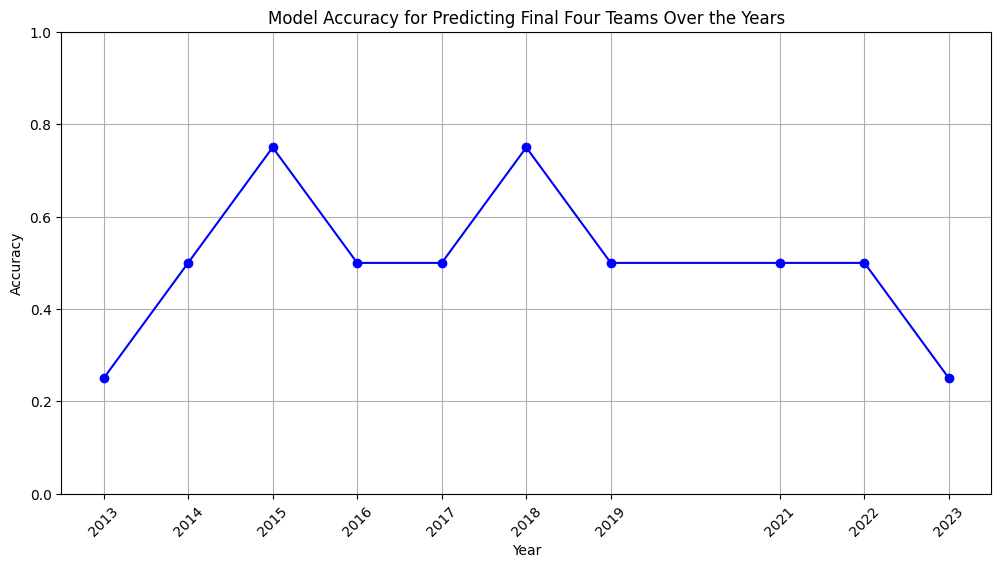

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting unique years from the dataset
years = df['YEAR'].unique()
accuracies = []

# Loop over each year to predict postseason outcomes and calculate accuracy
for year in sorted(years):
    # Filter data for the current year
    df_year = df[df['YEAR'] == year]
    if df_year.empty:
        continue
    
    # Process the data for prediction: dropping irrelevant columns and performing SVD
    X_year = np.linalg.svd(df_year.drop(columns=['TEAM', 'CONF', 'POSTSEASON', 'SEED', 'YEAR']).astype(np.float64), full_matrices=False)[0][:, :5]
    
    # Predict the POSTSEASON outcomes using the trained model
    y_pred_year = model.predict(X_year)
    
    # Identify teams predicted to reach the Final Four
    final_four_indices = np.argsort(y_pred_year)[-4:]
    predicted_final_four_teams = label_encoders['TEAM'].inverse_transform(df_year.iloc[final_four_indices]['TEAM'])
    
    # Extract rows where teams actually reached the Final Four or better
    actual_final_four_teams = df_year[df_year['POSTSEASON'].isin([6, 7, 8])]  # F4=6, 2ND=7, Champions=8
    
    # Convert team IDs to names for the actual Final Four teams
    actual_final_four_team_names = label_encoders['TEAM'].inverse_transform(actual_final_four_teams['TEAM'])
    
    # Calculate prediction accuracy
    predicted_teams_set = set(predicted_final_four_teams)
    actual_teams_set = set(actual_final_four_team_names)
    correct_predictions = predicted_teams_set.intersection(actual_teams_set)
    accuracy = len(correct_predictions) / 4  
    accuracies.append(accuracy)

# Plot the accuracies for each year
plt.figure(figsize=(12, 6))
plt.plot(sorted(years), accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Accuracy')
plt.title('Model Accuracy for Predicting Final Four Teams Over the Years')
plt.grid(True)
plt.xticks(sorted(years), rotation=45) 
plt.ylim(0, 1) 
plt.show()
